# **Home Assignment: Deep Learning from Scratch**

In [20]:
# Install a conda package in the current Jupyter kernel
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
warnings.simplefilter("ignore")
from scipy import io
import matplotlib.pyplot as plt


# Part I: the classifier and optimizer
## Subsection I - Softmax and its gradient

we will start by loading the dataset PeaksData

In [21]:
import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')

In [22]:
X = mat['Yt']
Y = mat['Ct']
X_val = mat['Yv']
Y_val = mat['Cv']
print(X.shape)
print(Y.shape)

(2, 25000)
(5, 25000)


we will now define the softmax function, and its gradient with respect to the weigths,baises and data.

In [400]:
import numpy as np

class softmax:
    def gradient(self, X, Y, error, W):
        M = X.shape[1]
        grad_theta = 1/M * error.dot(X.T)
        grad_b = 1/M * np.sum(error, axis=1)
        grad_data = 1/M * W.T.dot(error)
        return grad_theta, grad_b, grad_data
        
    def __call__(self, x):
        exp = np.exp(x)
        return (exp / np.sum(exp, axis=0))

we will now define our loss function which is the cross_entropy_loss(we assume that the predicted data is provided after softmax)

In [401]:
def cross_entropy_loss(y_true, y_predicted, epsilon=1e-10):
    predictions = np.clip(y_predicted, epsilon, 1. - epsilon)
    M = predictions.shape[1]
    return -np.sum(y_true * np.log(predictions)) / M

we will now define a simple linear layer which will be later used as a building block to our nueral network. a simple linear layer consists of activation function and linear function $ A^TX + B $.

In [478]:
class linear_layer:
    def __init__(self, dim_in, dim_out, activation):
        self._A = np.random.normal(.5, .5, size=(dim_out, dim_in))
        self._B = np.random.normal(.5, .5, size=(dim_out, 1))
        self._activation = activation
        self._dim_in = dim_in
        self._dim_out = dim_out
        
    def update_weigths(self, gradient_theta, gradient_b, learning_rate):
        gradient_b = gradient_b.reshape(self._dim_out, 1)
        self._A = self._A - learning_rate * gradient_theta
        self._B = self._B - learning_rate * gradient_b
    
    def gradient(self, X, Y, error):
        return self._activation.gradient(X, Y, error, self._A)
    
    def dim_in(self):
        return self._dim_in
    
    def dim_out(self):
        return self._dim_out
    
    def activate_with_weigths_change(self, d, x):
        return self._activation((self._A + d).dot(x) + self._B)
        
    def activate_with_biases_change(self, d, x):
        return self._activation(self._A.dot(x) + (self._B + d))
    
    def jacobain(self, X, Y, vec, kind):
        return self._activation.jacobain(X, Y, self._A, vec, kind)
    
    def __call__(self, x):
        return self._activation(self._A.dot(x) + self._B)

in general the gradient test is defined as follows : we know that $ |f(x + \epsilon*d) - f(x)| = O(\epsilon) $ , we want to check that $ |f(x + \epsilon*d) - f(x) - \epsilon*d*grad(x)| = O(\epsilon^2) $ <br>
we can now check that our linear function with softmax activation passes the gradient test, where f(x) = cross_entropy_loss. we will start by checking the gradient with respect to the data.<br>
notice that since we only check the gradient with respect to the data , the random vector $ \epsilon * d $ is added the data in the following way $ f(\sigma(A^T(X + \epsilon * d) + b)) $

In [403]:
def create_random_vector(dim_in, dim_out):
    d = np.random.normal(.5, .5, size=(dim_in, dim_out))
    return d / np.linalg.norm(d)

def gradient_test_with_respect_to_data(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d_input = create_random_vector(dim_in, 1)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d_input
        predictions = linear_layer(X)
        predictions_d = linear_layer(X + vec)
        _, _, grad_data = linear_layer.gradient(X, Y, predictions - Y)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        with_gradient.append(np.abs(diff_f - vec.T.dot(grad_data).reshape(1)))
    return without_gradient, with_gradient

in each iteration of the gradient test we define $ \epsilon = 0.5^i $ where i is the number of the current iteration. <br>
we will then draw those 2 lines in log scale, and we expect that the second formula(with the gradient) will converge faster.

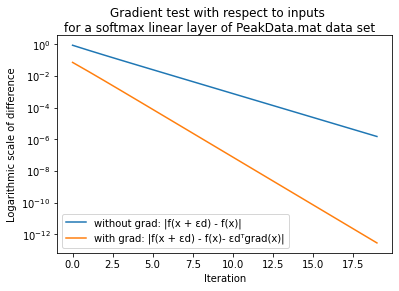

In [404]:
without_grad, with_grad = gradient_test_with_respect_to_data(cross_entropy_loss, linear_layer(2,5, softmax()),
                                                               X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

we will now test the gradient with respect to the baises, agian the basic idea of the gradient test applies, we only need to add the random vector $ \epsilon * d $ to the baises instead of the data in the first test $ f(\sigma(A^TX + (b + \epsilon * d))) $ <br>
obviously we will now use the gradient of the softmax function with respect to the baises.

In [405]:
def gradient_test_with_respect_to_baises(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, 1)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_biases_change(vec, X)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        _, grad_baises, _ = linear_layer.gradient(X, Y, predictions - Y)
        with_gradient.append(np.abs(diff_f - vec.T.dot(grad_baises).reshape(1)))
    return without_gradient, with_gradient

we expect the same result here as we got in the gradient test with respect to the data

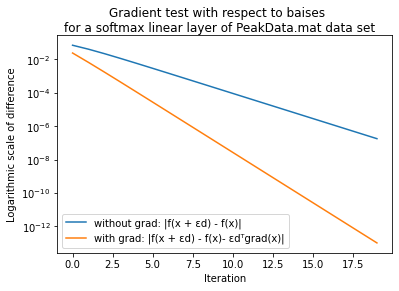

In [406]:
without_grad, with_grad = gradient_test_with_respect_to_baises(cross_entropy_loss, linear_layer(2,5, softmax()),
                                                               X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to baises \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

now for the final test, we will test the gradient with respect to the weigths. we will now add the random vector $ \epsilon * d $ to the weights as follows : $ f(\sigma((A+\epsilon * d)^TX + b)) $

In [407]:
def gradient_test_with_respect_to_weigths(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, dim_in)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_weigths_change(vec, X)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        grad_theta, _, _ = linear_layer.gradient(X, Y, predictions - Y)
        with_gradient.append(np.abs(diff_f - (np.ravel(vec) @ np.ravel(grad_theta)).reshape(1)))
    return without_gradient, with_gradient

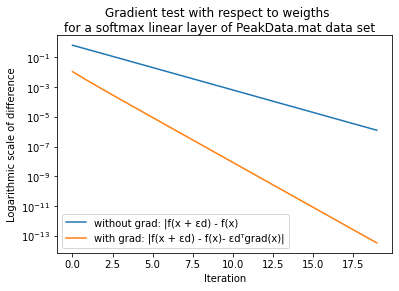

In [412]:
without_grad, with_grad = gradient_test_with_respect_to_weigths(cross_entropy_loss, linear_layer(2,5, softmax()),
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to weigths \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

## Subsection II - SGD
we can clearly see that our linear_layer passes the gradient test and we can move on to the second part, which is writing the SGD. but before we do that we will define the class sequential_model which is just a wrapper over some linear_layers, and will help use in the SGD and calculting the output of the model.

In [413]:
class sequential_model:
    def __init__(self, *layers):
        self._layers = []
        self._history = []
        last_dim_out = 0
        for layer in layers:
            if last_dim_out != 0 and last_dim_out != layer.dim_in():
                print('dimension dont match layer out dim {} , next layer dim in {}'.format(last_dim_out, layer.dim_in()))
                raise 
            self._layers.append(layer)
            last_dim_out = layer.dim_out()

    def seq_gradient(self, Y_true):
        gradient = []
        error = self._history[-1] - Y_true
        for i in range(1, len(self._layers) + 1):
            X = self._history[-i - 1]
            Y = self._history[-i]
            gradient_theta, gradient_b, error = self._layers[-i].gradient(X, Y, error)
            gradient.append((gradient_theta, gradient_b, error, X, Y))
        return gradient
            
    def activate_from_layer(self, x, layer_num):
        new_x = np.array(x, copy=True)
        for layer in self._layers[layer_num:]:
            new_x = layer(new_x)
        return new_x
    
    def activate_from_layer_with_weigths_change(self, x, d, layer_num):
        new_x = np.array(x, copy=True)
        new_x = self._layers[layer_num].activate_with_weigths_change(d, new_x)
        for layer in self._layers[layer_num + 1:]:
            new_x = layer(new_x)
        return new_x
    
    def activate_from_layer_with_baises_change(self, x, d, layer_num):
        new_x = np.array(x, copy=True)
        new_x = self._layers[layer_num].activate_with_biases_change(d, new_x)
        for layer in self._layers[layer_num + 1:]:
            new_x = layer(new_x)
        return new_x

    def __call__(self, x):
        new_x = np.array(x, copy=True) 
        self._history = []
        self._history.append(new_x)
        for layer in self._layers:
            new_x = layer(new_x)
            self._history.append(new_x)
        return new_x

    def layers(self):
        return self._layers
    
    def history(self):
        return self._history

we will define accuracy function, which is just $ \frac{argmax(Y_{true}) = argmax(Y_{predicted})}{size} $

In [414]:
def accuracy(Y_true, Y_predicted):
    return np.sum(np.argmax(Y_true, axis=0) == np.argmax(Y_predicted, axis=0)) / Y_true.shape[1]

now we will define out SGD , this function receive the model as input and in each epoch , it update the weigths based on the gradient and then calculate the accuracy the the loss for the train set and the validation set.<br>
importent thing to note is that each layer update is own weights with the calculated gradient.

In [415]:
import math

def update_weigths(layers, history, learning_rate, Y_true):
    error = history[-1] - Y_true
    for i in range(1, len(layers) + 1):
        X = history[-i - 1]
        Y = history[-i]
        gradient_theta, gradient_b, error = layers[-i].gradient(X, Y, error)
        layers[-i].update_weigths(gradient_theta, gradient_b, learning_rate)


def SGD(model, X, Y, X_val, Y_val, epoch, learning_rate, loss, batch_size):
    accuracy_train = []
    accuracy_val = []
    loss_train = []
    loss_val = []
    number_of_iterations = math.ceil(X.shape[1] / batch_size)
    for i in range(epoch):
        iter_accuracy = 0
        iter_loss = 0
        for j in range(0, X.shape[1], batch_size):
            Y_predicted = model(X[:, j:j+batch_size])
            update_weigths(model.layers(), model.history(), learning_rate, Y[:, j:j+batch_size])
            iter_accuracy += accuracy(Y[:, j:j+batch_size], Y_predicted)
            iter_loss += loss(Y[:, j:j+batch_size], Y_predicted)
        Y_predicted_val = model(X_val)
        accuracy_train.append(iter_accuracy / number_of_iterations)
        loss_train.append(iter_loss / number_of_iterations)
        accuracy_val.append(accuracy(Y_val, Y_predicted_val))
        loss_val.append(cross_entropy_loss(Y_val, Y_predicted_val))
    return loss_train, accuracy_train, loss_val, accuracy_val

we will now check that the SGD minimize the objective function.

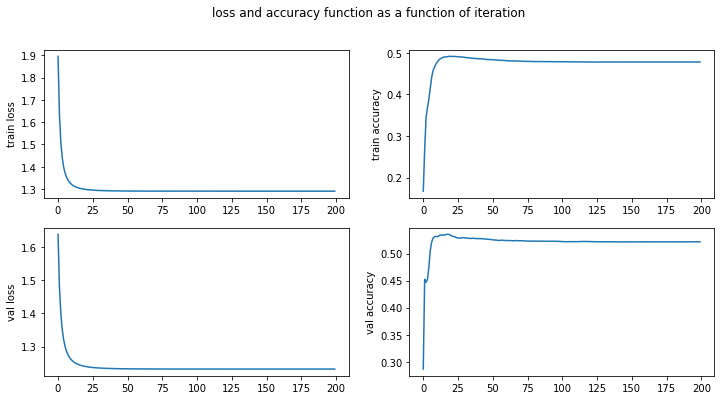

In [416]:
import matplotlib.pyplot as plt

model = sequential_model(
        linear_layer(2, 5, activation=softmax())
        )

train_loss, train_accuracy, val_loss, val_accuracy = SGD(model, X, Y, X_val, Y_val, 200, 0.1, cross_entropy_loss, 2500)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy)
axs[1][1].set_ylabel('val accuracy')

plt.show()

## Subsection III - SGD Hyper Parameters

we will now define grid search function, which given some hyper paramters lists, try all the combinations for the best result.

In [417]:
def grid_search(model_init, X, Y, X_val, Y_val, learning_rate_values, iteration_values, batch_size_values):
    train_accuracy = []
    val_accuracy = []
    val_loss = []
    train_loss = []
    for learning_rate in learning_rate_values:
        for iteration_num in iteration_values:
            for batch_size in batch_size_values:
                model = model_init()
                loss_train, accuracy_train, loss_val, accuracy_val = SGD(model, X, Y, X_val, Y_val, iteration_num, learning_rate, cross_entropy_loss, batch_size)
                train_accuracy.append(accuracy_train)
                val_accuracy.append(accuracy_val)
                train_loss.append(loss_train)
                val_loss.append(loss_val)
    return train_accuracy, train_loss, val_accuracy, val_loss

we will now test our grid function and plot the best results, according to the best validation accuracy.

In [418]:
learning_rates = [0.2, 0.1, 0.05, 0.01, 0.001]
iteration_values = [10, 20, 50, 100, 200]
batch_sizes = [50, 100, 500, 1000, 25000]

train_accuracy, train_loss, val_accuracy, val_loss = grid_search(lambda : sequential_model(linear_layer(2, 5, activation=softmax())), X, Y, X_val, Y_val, learning_rates, iteration_values, batch_sizes)

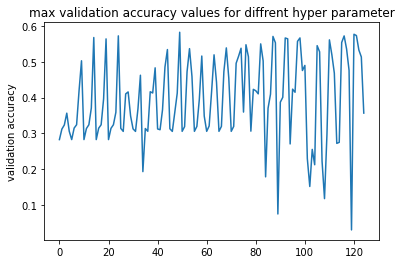

In [419]:
max_values = list(map(lambda x : max(x), val_accuracy))

plt.plot(max_values)
plt.title("max validation accuracy values for diffrent hyper parameter")
plt.ylabel('validation accuracy')
plt.show()

we can see that increasing the batch size relly effect the performence of the mode, and smaller learning rates with very small number of iterations results in an underfitted model as expected.

the best val accuracy is obtained using learning_rate = 0.1, num_iterations = 200, batch_size = 25000
best accuracy : 0.5824


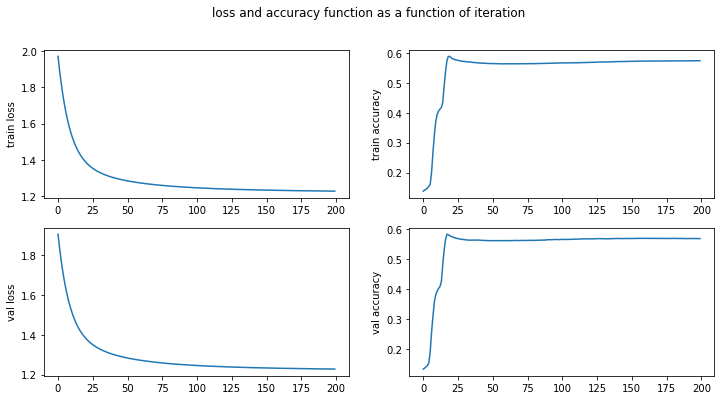

In [422]:
index = np.argmax(max_values)

print('the best val accuracy is obtained using learning_rate = {}, num_iterations = {}, batch_size = {}'.format(learning_rates[int(index / 25)], iteration_values[int(index / 5) % 5], batch_sizes[index % 5]))
print('best accuracy : {}'.format(np.max(max_values)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss[index])
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy[index])
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss[index])
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy[index])
axs[1][1].set_ylabel('val accuracy')

plt.show()

# Part II: the neural network
## Subsection I : NN and Jacobain Tests

we will first declare a new activation function, tanh and its gradient.

In [585]:
class tanh:
    def gradient(self, X, Y, error, W):
        new_error = (1 - Y**2) * error
        grad_theta = X.dot(new_error.T)
        grad_b = np.sum(new_error, axis=1)
        grad_data = W.dot(new_error)
        return grad_theta, grad_b, grad_data
    
    def jacobain(self, X, Y, W, vec, kind):
        derv = (1 - Y**2)
        derv = np.identity(len(derv)) * np.outer(np.ones(len(derv)), derv)
        if kind == 'x':
            return derv.dot(W).dot(vec)
        if kind == 'w':
            new_X = np.kron(X.T, np.identity(W.shape[0]))
            derv = derv.dot(new_X)
            return derv.dot(np.ravel(vec, order="F"))
        if kind == 'b':
            return derv.dot(vec)
        
    def __call__(self, x):
        return np.tanh(x)

we will now create the jacobain test for a simple linear layer with tanh activation function.

In [586]:
def jacobain_test_with_respect_to_inputs(linear_layer, X, Y):
    without_jacobain = []
    with_jacobain = []
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_in, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer(X + vec)
        jacob = linear_layer.jacobain(X, predictions, vec, 'x')
        diff_f = predictions_d - predictions
        without_jacobain.append(np.linalg.norm(diff_f))
        with_jacobain.append(np.linalg.norm(diff_f - jacob))
    return without_jacobain, with_jacobain

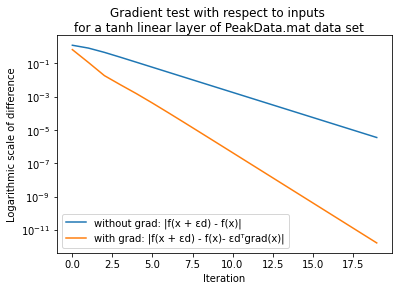

In [587]:
without_grad, with_grad = jacobain_test_with_respect_to_inputs(linear_layer(2,5, tanh()),
                                                               X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a tanh linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

In [588]:
def jacobain_test_with_respect_to_weigths(linear_layer, X, Y):
    without_jacobain = []
    with_jacobain = []
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, dim_in)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_weigths_change(vec, X)
        jacob = linear_layer.jacobain(X, predictions, vec, 'w')
        diff_f = predictions_d - predictions
        without_jacobain.append(np.linalg.norm(diff_f))
        with_jacobain.append(np.linalg.norm(diff_f - jacob))
    return without_jacobain, with_jacobain

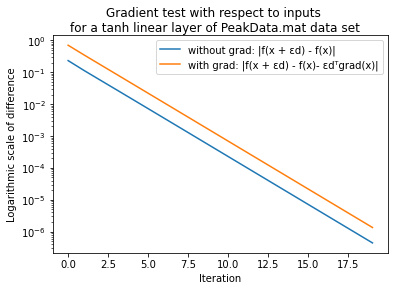

In [589]:
without_grad, with_grad = jacobain_test_with_respect_to_weigths(linear_layer(2,5, tanh()),
                                                               X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a tanh linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

In [590]:
def jacobain_test_with_respect_to_biases(linear_layer, X, Y):
    without_jacobain = []
    with_jacobain = []
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_biases_change(vec, X)
        jacob = linear_layer.jacobain(X, predictions, vec, 'b')
        diff_f = predictions_d - predictions
        without_jacobain.append(np.linalg.norm(diff_f))
        with_jacobain.append(np.linalg.norm(diff_f - jacob))
    return without_jacobain, with_jacobain

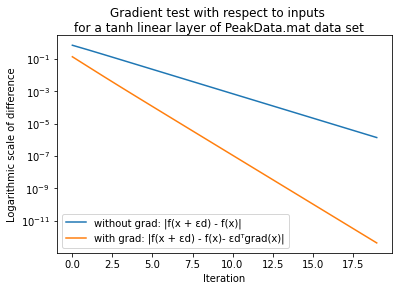

In [591]:
without_grad, with_grad = jacobain_test_with_respect_to_biases(linear_layer(2,5, tanh()),
                                                               X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a tanh linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

In [468]:
def relu_der (x):
    if x > 0:
        return 1
    else :
        return 0
relu_der2  = np.vectorize(relu_der)

class relu:
    def gradient(self, X, Y, error, W):
        M = X.shape[1]
        a = relu_der2(Y)
        error2 = error * a
        grad_theta = X.dot(error2.T)
        grad_b = np.sum(error2, axis=1)
        grad_data = W.dot(error2)
        return grad_theta, grad_b, grad_data

        
    def __call__(self, x):
        return (abs(x)+x)/2

In [304]:
def model_gradient_test_with_respect_to_inputs(loss, model, X, Y):
    without_jacobain = np.ndarray(shape=(len(model.layers()), 20))
    with_jacobain = np.ndarray(shape=(len(model.layers()), 20))
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d =  np.random.normal(.5, .5, size=(layers[j].dim_in(), 1))
        d = d / np.linalg.norm(d)
        d_array.append(d)
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        loss_predictions = loss(Y, predictions)
        grad = model.seq_gradient(Y)
        layers = model.layers()
        for j in range(1, lay_len + 1):
            _, _, grad_data, X_current, predictions = grad[j - 1]
            vec = e * d_array[-j]
            loss_predictions_d = loss(Y, model.activate_from_layer(X_current + vec, lay_len - j))
            diff_f = loss_predictions_d - loss_predictions
            without_jacobain[j - 1][k] = np.abs(diff_f)
            with_jacobain[j - 1][k] = np.abs(diff_f - vec.T.dot(grad_data).reshape(1))
    return np.sum(without_jacobain, axis=0), np.sum(with_jacobain, axis=0)

In [305]:
def model_gradient_test_with_respect_to_baises(loss, model, X, Y):
    without_jacobain = np.ndarray(shape=(len(model.layers()), 20))
    with_jacobain = np.ndarray(shape=(len(model.layers()), 20))
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d =  np.random.normal(.5, .5, size=(layers[j].dim_out(), 1))
        d = d / np.linalg.norm(d)
        d_array.append(d)
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        loss_predictions = loss(Y, predictions)
        grad = model.seq_gradient(Y)
        layers = model.layers()
        for j in range(1, lay_len + 1):
            _, grad_b, _, X_current, predictions = grad[j - 1]
            vec = e * d_array[-j]
            predictions_d = model.activate_from_layer_with_baises_change(X_current, vec, lay_len - j)
            loss_predictions_d = loss(Y, predictions_d)
            diff_f = loss_predictions_d - loss_predictions
            without_jacobain[j - 1][k] = np.abs(diff_f)
            with_jacobain[j - 1][k] = np.abs(diff_f - vec.T.dot(grad_b).reshape(1))
    return np.sum(without_jacobain, axis=0), np.sum(with_jacobain, axis=0)

In [306]:
def model_gradient_test_with_respect_to_weigths(loss, model, X, Y):
    without_jacobain = np.ndarray(shape=(len(model.layers()), 20))
    with_jacobain = np.ndarray(shape=(len(model.layers()), 20))
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d =  np.random.normal(.5, .5, size=(layers[j].dim_in(), layers[j].dim_out()))
        d = d / np.linalg.norm(d)
        d_array.append(d)
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        loss_predictions = loss(Y, predictions)
        grad = model.seq_gradient(Y)
        layers = model.layers()
        for j in range(1, lay_len + 1):
            grad_theta, _, _, X_current, predictions = grad[j - 1]
            vec = e * d_array[-j]
            predictions_d = model.activate_from_layer_with_weigths_change(X_current, vec, lay_len - j)
            loss_predictions_d = loss(Y, predictions_d)
            diff_f = loss_predictions_d - loss_predictions
            without_jacobain[j - 1][k] = np.abs(diff_f)
            with_jacobain[j - 1][k] = np.abs(diff_f - (np.ravel(vec) @ np.ravel(grad_theta)).reshape(1))
    return np.sum(without_jacobain, axis=0), np.sum(with_jacobain, axis=0)

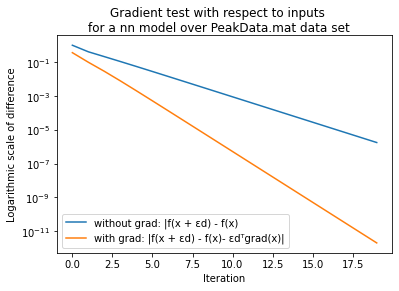

In [309]:
model = sequential_model(
        linear_layer(2, 5, activation=tanh()),
        linear_layer(5, 5, activation=tanh()),
        linear_layer(5, 5, activation=relu()),
        linear_layer(5, 5, activation=softmax())
        )


without_grad, with_grad = model_gradient_test_with_respect_to_inputs(cross_entropy_loss, model,
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

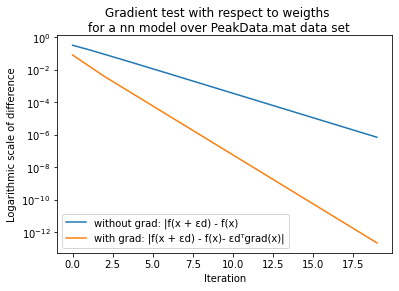

In [314]:
without_grad, with_grad = model_gradient_test_with_respect_to_weigths(cross_entropy_loss, model,
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to weigths \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

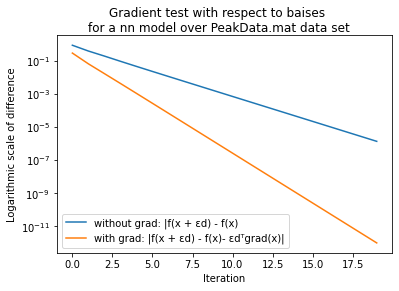

In [313]:
without_grad, with_grad = model_gradient_test_with_respect_to_baises(cross_entropy_loss, model,
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to baises \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

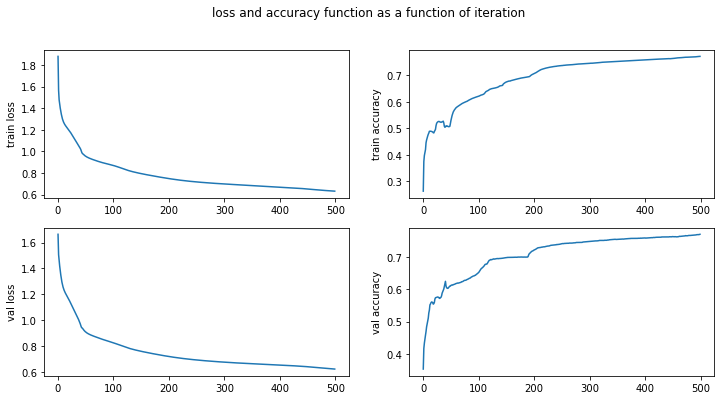

In [293]:
model = sequential_model(
        linear_layer(2, 4, activation=tanh()),
        linear_layer(4, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 5, activation=softmax())
)

loss_train, accuracy_train, loss_val, accuracy_val = SGD(model, X, Y, X_val, Y_val, 500, 0.1, cross_entropy_loss, 2500)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(loss_train)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(accuracy_train)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(loss_val)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(accuracy_val)
axs[1][1].set_ylabel('val accuracy')

plt.show()

3. *Compute a forward pass and a backward pass of a network with L layers (L is a parameter). See that the gradient of the whole network (softmax + layers) passes the gradient test. Submit this verification.*

3. *Repeat section 3 for the entire network. Try a few network lengths and see how this influences the performance. Write your conclusions and demonstrate them.*